## Overview

This is the code for homework 4 of the Big Data Computing course. The goal is to perform document clustering using k-means and SVD. This notebook is organized into 7 numbered sections so that it can be read and executed in a modular approach. You can run all the sections or part of them, following the instructions described in this introduction.

All the sections related to heavier computations (3.1, 3.2, 5.1) contain the lines of code used to write the result of the corresponding computation to a file. In this way, by retrieving data from the files, it is possible to skip some slow portions of the code to run only the needed ones. This notebook comes with all the files already created.

**Disclaimer 1:** In this notebook, it is used the functionality of mounting Google Drive on Colab to manage the files. If you are using another environment, be careful to include the files if you don't want to recreate them from scratch. In any case, change the file paths (defined in section 2) to suit your needs. If the paths are not correctly defined, you will not be able to run the code.

**Disclaimer 2:**  Running the writing lines of this notebook may destroy or corrupt the integrity of the mentioned files. To avoid unintentional execution, all the writing lines are commented out. Uncomment them to perform the actual writing (you can change the name of the destination files to keep the original ones safe).

### Details

1. **Import:** It contains all needed libraries and functions to properly execute the other sections.
2. **File paths:** Here is the definition of the file paths. Files are downloaded from the kaggle dataset Amazon Books Reviews (https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews).
3. **Preprocessing:** It contains the needed steps to perform the preprocessing of the data obtained 
> 1. **Retrieve data:** It reads data from the kaggle dataset Amazon Books Reviews
> 2. **Perform data cleaning:** It contains the function 'preprocessing' used to compute the actual transformation of the texts. When the function is called, it is possible to enable/disable some preprocessing steps among the implemented ones (expand contractions, discard tags, delete punctuations, delete numbers, apply -principled- lemmatization and delete stopwords) using the 'options' dictionary as a function parameter. 
> 3. **Perform typos correction:** Reviews written by Amazon users are often full of errors. This section contains the code needed to apply a step of spelling correction and to filter out all non-english words (applied only partially in our calculation).
4. **Create tf-idf vectors:** It reads the preprocessed data and creates the vectorized representation. Changing the parameter that filters out terms with higher (and lower) document frequency can greatly affect the result either positively or negatively.
5. **k-means:** It implements clustering using k-means algorithm
> 1. **Compute inertia:** It stores inertia and silhoutte score values for different values of k in a file. It is useful for applying the elbow method and selecting the optimal clustering parameter.
> 2. **Elbow:** It reads the file containing the previous results and plots inertia values.
> 3. **Clustering:** It performs the actual clustering step and retrieves keywords for each identified cluster.
6. **SVD:** It implements clustering using SVD
> 1. **Explained variance:** It computes and plots the explained variance ratio for selecting the optimal clustering parameter.
> 2. **Clustering:** It performs the actual clustering step and retrieves keywords for each identified cluster.
7. **Random projections:** It recomputes text clustering using k-means as in section 5, but this time a preliminar phase of random projections is used. This is useful to speed up the computation.

Some specific details of the implementation are described in the comments, so you can understand them when reading the code.

### How to run

Here are the numbers associated to the sections strictly necessary to perform each task

* **Preprocess data:** 1 -> 2 -> 3
* **Create tf-idf vectors:** 1 -> 2 -> 4
* **Compute inertia for elbow method (from scratch):** 1 -> 2 -> 4 -> 5.1
* **Plot inertia for elbow method:** 1 -> 2 -> 5.2
* **Apply k-means for text clustering:** 1 -> 2 -> 4 -> 5.3
* **Plot explained variance computed by SVD:** 1 -> 2 -> 6.1
* **Apply SVD for text clustering:** 1 -> 2 -> 4 -> 6.2
* **Apply random projections + k-means for text clustering:** 1 -> 2 -> 4 -> 7

If you use Google Colab and run all the sections without interruption, you may experience crashes due to the limited resources provided by Colab. In any case, each of the above tasks can be completed safely. It is therefore advisable to restart when you finish one of the tasks.

### Final considerations

The ultimate goal is to perform text clustering and keyword extraction to understand people's tastes in books. In all three implemented methods, there is a final part of the code that allows the user to analyze the themes related to each cluster. In detail, it is possible to print out the most relevant terms for each cluster, but it is also possible to try to guess favorite genres and topics. To do this, two different lists are used: the first ('genres') is hard-coded with some popular book genres; the second ('categories') is composed of elements retrieved from a field in the original dataset and modified so as to avoid maintaining an explicit relationship between topics and related books (clustering is an unsupervised learning problem, as defined by the machine learning community).

One important phase of the clustering algorithms is how to choose the parameter k. In this notebook it is used the elbow method by plotting the inertia values for increasing values of k. To drive the tests it has been chosen k=17. Actually, there is no clear elbow and calculating a more refined score (e.g., silhouette score) can be effective in finding the best clustering. In addition, the results are also strongly influenced by the vectorization stage and how one chooses to filter the most frequent and least frequent terms in the collection. To achieve satisfactory keyword extraction, trial and error may be necessary.

Running times using Colab (k=17):

* Time to execute clustering with k-means: 311.317 s
* Time to execute clustering with SVD: 166.742 s
* Time to execute clustering with random projections + k-means: 27.695 s

## 1) Import

In [ ]:
# comment these lines if you don't use Google Colab
from google.colab import drive
drive.mount('/content/drive')

import json
import string
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, words
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection as srp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## 2) File paths

In [ ]:
data_file = '/content/drive/MyDrive/books_data.csv'
rating_file = '/content/drive/MyDrive/books_rating.csv'
preprocessed_file = '/content/drive/MyDrive/hw4_preprocessed.csv'
spell_corr_file = '/content/drive/MyDrive/spelling_correction.txt'
elbow_file = '/content/drive/MyDrive/elbow.txt'

## 3) Preprocessing

### 3.1) Retrieve data

In [ ]:
# read and clear the first dataset (containing general informations about the books)
df = pd.read_csv(data_file, sep=',')
df.dropna(subset=['Title', 'categories'], inplace=True)

# extract useful informations
# (books' categories will be used after the clustering to drive conclusion about the topics of the clusters)
categories_dict = {}

for idx, title in enumerate(df['Title']):
  categories_dict.setdefault(title, df['categories'].tolist()[idx].split("'")[1])

In [ ]:
# read and clear the second dataset (containing informations about the reviews)
df = pd.read_csv(rating_file, sep=',')
df.dropna(subset=['Title', 'review/helpfulness', 'review/summary', 'review/text'], inplace=True)

# extract useful informations
# (the helpfulness score is converted into a float; when there is no score (0/0), the review is considered helpful (1/1) by default)
titles = df['Title'].tolist()
helpfulness = [int(h.split('/')[0])/int(h.split('/')[1]) for h in list(map(lambda x: '1/1' if x == '0/0' else x, df['review/helpfulness']))]
summaries = df['review/summary'].tolist()
texts = df['review/text'].tolist()

### 3.2) Perform data cleaning

In [ ]:
contracts = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

# define preprocessing pipeline
def preprocessing(string, contracts, puncts, options):
  # convert all characters into lowercase characters 
  string = string.lower()
  
  # expand any contractions using 'contracts' dictionary
  if options.get("expand_contractions"):
    for pair in contracts.items():
      if pair[0] in string:
        string = string.replace(pair[0], pair[1])

  # delete any punctuation symbols using 'puncts' list
  if options.get("del_punctuations"):
    for punct in puncts:
      if punct in string:
        string = string.replace(punct, " ")
  
  # delete any numbers
  if options.get("del_numbers"):
    for num in list(range(0, 10)):
      if str(num) in string:
        string = string.replace(str(num), " ")
  
  # correct typos
  if options.get("check_spelling"):
    string = str(TextBlob(string).correct())

  # apply lemmatization
  if options.get("use_lemmatization"):
    lemmatizer = WordNetLemmatizer()

    # principled strategy based on part-of-speech tags (inspired by https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
    pos_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    string = " ".join([lemmatizer.lemmatize(pair[0], pos_dict.get(pair[1][0].upper(), wordnet.NOUN)) for pair in pos_tag(word_tokenize(string))])

    ''' alternative
    string = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(string)])
    '''

  # delete stopwords
  if options.get("del_stopwords"):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    string = " ".join([word for word in word_tokenize(string) if word not in stopwords])

  return string

In [ ]:
# choose how to preprocess data
# (the spelling correction is executed later to decouple it from the rest of preprocessing steps)
options = {"expand_contractions": True,
           "del_punctuations": True,
           "del_numbers": True,
           "check_spelling": False,
           "use_lemmatization": True,
           "del_stopwords": True}

for title, category in categories_dict.items():
  categories_dict.update({title: preprocessing(category, contracts, puncts, options)})

summaries = [preprocessing(elem, contracts, puncts, options) for elem in summaries]
texts = [preprocessing(elem, contracts, puncts, options) for elem in texts]
# due to the long running time, the actual preprocessing was not done in one go,
# but by dividing the data into several chuncks (for both summaries and texts)

In [ ]:
# write preprocessed data into a csv file
# uncomment the following lines to perform the actual writing
'''
f_csv = open(preprocessed_file, "w")
f_csv.write("title\tcategory\thelpfulness\tsummary\ttext\n")

for i in range(len(titles)):
  f_csv.write(str(titles[i]) + "\t" + str(categories_dict.get(titles[i])) + "\t" + str(helpfulness[i]) + "\t" + str(summaries[i]) + "\t" + str(texts[i]) + "\n")

f_csv.close()
'''

### 3.3) Perform typos correction

In [ ]:
# read preprocessed data
df = pd.read_csv(preprocessed_file, sep='\t')

helpfulness = df['helpfulness'].tolist()
summaries = df['summary'].tolist()
texts = df['text'].tolist()

# design choice: each document contains a reconciled string composed of 'summaries' and 'texts'
# design choice: reviews with an helpfulness score under a certain (low) threshold are discarded (they may be poor quality reviews)
# comment the following line to ignore the previous choices
texts = [str(s) + " " + str(t) for (s, t, h) in zip(summaries, texts, helpfulness) if h > 0.15]

In [ ]:
texts = [str(TextBlob(elem).correct()) for elem in texts]
# as for data cleaning, it is better to create small chuncks and perform the computation one portion at a time
# the running time is quite long and this step was done only for about 75% of the reviews

In [ ]:
# to complete the preprocessing, it is possible to filter out non-english words
# this last step is not executed in our implementation
# uncomment the following lines if you want to perform this step
'''
res = []
for text in texts:
  words_lst = text.replace('\n', '').split(' ')
  res.append(' '.join([word for word in words_lst if word in words.words()]))
'''

In [ ]:
# write preprocessed data into a csv file
# uncomment the following lines to perform the actual writing
'''
f = open(spell_corr_file, "w")

for elem in texts:
  f.write(elem)
  f.write('\n')

f.close()
'''

## 4) Create tf-idf vectors

In [ ]:
# read preprocessed reviews
f = open(spell_corr_file, "r")

texts = []
for line in f:
  texts.append(line[:-1])

f.close()

In [ ]:
# compute the tf-idf vectors (lower max_df parameter to limit the number of terms)
vectorizer = TfidfVectorizer(max_df=0.5) 
texts_tfidf = vectorizer.fit_transform(texts)
texts_tfidf.shape

(2729828, 623874)

## 5) k-means

### 5.1) Compute inertia

In [ ]:
# compute inertia and silhouette score values for increasing value of k
K = range(2, 55)
score_lst = []

for k in K:  
  kmeans = MiniBatchKMeans(n_clusters=k, init='random', n_init=100, max_iter=300, batch_size=2**17)
  kmeans.fit(texts_tfidf)

  inertia = kmeans.inertia_
  silhouette = silhouette_score(texts_tfidf, kmeans.predict(texts_tfidf), sample_size=2**17)
  
  score_lst.append([k, inertia, silhouette])
  print(score_lst[-1])

In [ ]:
# write the previously computed values
# uncomment the following lines to perform the actual writing
'''
f = open(elbow_file, "w")

for elem in score_lst:
  f.write(json.dumps(elem))
  f.write('\n')

f.close()
'''

### 5.2) Elbow

In [ ]:
# retrieve inertia and silhouette score values
f = open(elbow_file, "r")

score_lst = []
for line in f:
  score_lst.append(json.loads(line))

f.close()

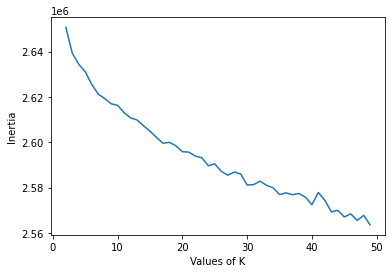

In [ ]:
# plot inertia values
K = range(2, 50)

plt.plot(K, [elem[1] for elem in score_lst[K.start-2:K.stop-2]])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.show()

# from the plot we cannot see any clear elbow
# we choose 17, but other values can be valid candidates such as 7 and 9

### 5.3) Clustering

In [ ]:
# apply k-means
k = 17

kmeans = MiniBatchKMeans(n_clusters=k, init='random', n_init=100, max_iter=300, batch_size=2**15)

start = time.time()
kmeans.fit(texts_tfidf)
end = time.time()

print("Executed in {:.3f}".format(end - start))

In [ ]:
# create 'genres' and 'categories' lists
df = pd.read_csv(preprocessed_file, sep='\t')

categories = df['category'].tolist()
categories = list(filter(lambda x: len(x) > 2, set([item for string in categories for item in str(string).split(' ')])))

genres = ['fiction', 'action', 'adventure', 'comic', 'romance', 'historical', 'fantasy', 'horror', 'thrill', 'mystery', 'western', 'science', 'biography', 'autobiography', 'art', 'travel', 'essay', 'guide', 'religion', 'spirituality', 'memoir', 'cookbook', 'development', 'motivation', 'humour', 'sport', 'crime', 'music', 'photography', 'drama', 'tragedy']

# compute terms and centroids
terms = vectorizer.get_feature_names_out()
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("Original dimensions: {}".format(texts_tfidf.shape))
print("Centroids dimensions: {}".format(centroids.shape))

Original dimensions: (2729828, 623874)
Centroids dimensions: (17, 623874)


Enter the action ('h' for help): 
k
Enter a number between 0 and 16 to identify a cluster (or 'all'): 
all
Cluster 0: good information use easy get would find need well buy


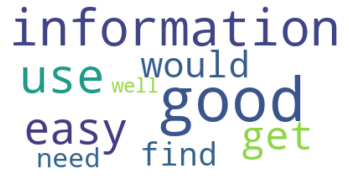

Cluster 1: quot one story like time would novel write life make


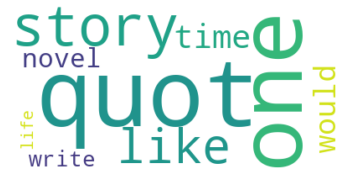

Cluster 2: war civil history world story american one time battle novel


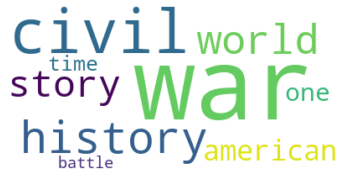

Cluster 3: favorite one time love story great year classic character novel


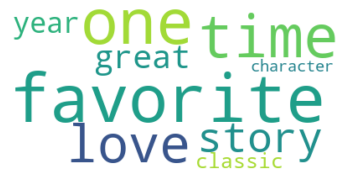

Cluster 4: great story enjoy series recommend good classic time one really


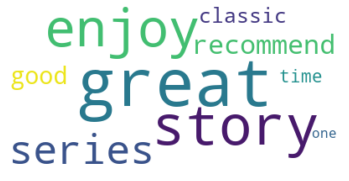

Cluster 5: must great anyone one classic time write story excellent get


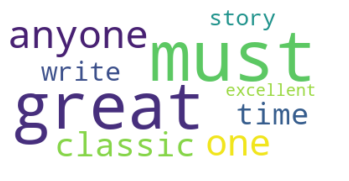

Cluster 6: best ever one write great time love good story think


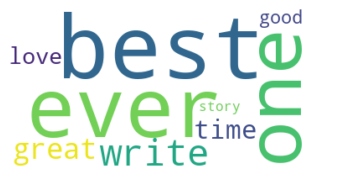

Cluster 7: one write work well time find make edition would get


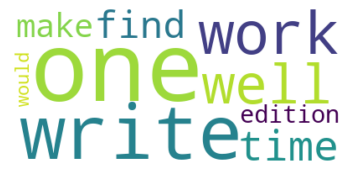

Cluster 8: quit one story like good time write would novel make


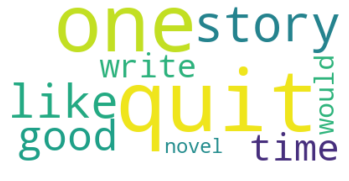

Cluster 9: love story great one time character jane classic get like


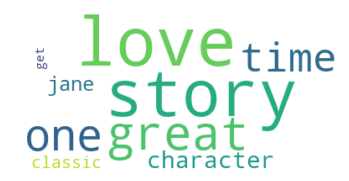

Cluster 10: character story novel one end plot time good write well


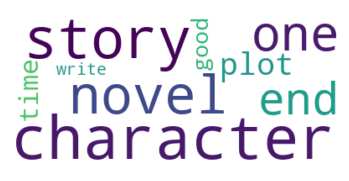

Cluster 11: life people one change make time way world think many


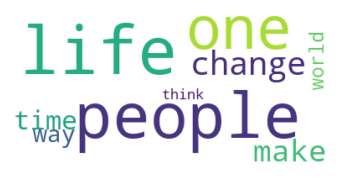

Cluster 12: like really good think would get one movie story go


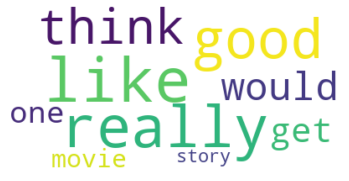

Cluster 13: woman year old story girl young family one time get


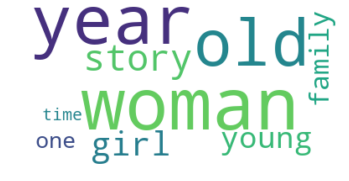

Cluster 14: child parent story adult love kid great old young one


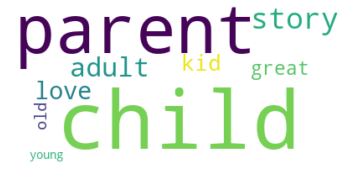

Cluster 15: funny science fiction laugh one story time like good loud


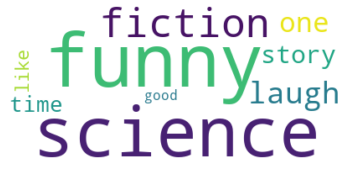

Cluster 16: god bible christian jesus church christ faith christianity life one


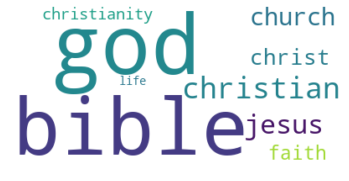

-------------------------------------------------
Enter the action ('h' for help): 
q


In [ ]:
# extract keywords and guess topics for each cluster
# (use 'k', 'c', 'g' actions to get keywords, categories and genres, respectively; use 'h' for help and 'q' for quit)
# (you can select one cluster using the relative number or all clusters using 'all')
quit = False
while not quit:
  print("Enter the action ('h' for help): ")
  action = input()

  if action == 'q':
    quit = True
    continue
  
  if action == 'h':
    print("Enter 'k' for keywords, 'c' for categories and 'g' for genres")
    print("Enter 'q' for quit")
    continue

  print("Enter a number between 0 and {} to identify a cluster (or 'all'): ".format(k-1))
  n = input()

  if n == 'all':
    n = -1

  if action == 'k':
    n_keywords = 10
    wc = WordCloud(background_color="white", max_words=n_keywords)
  if action == 'c':
    n_keywords = 10
    occ = {elem: 0 for elem in categories}
  if action == 'g':
    n_keywords = 200
    occ = {elem: 0 for elem in genres}
  
  for i in range(k):
    if i == int(n) or n == -1:
      centroid_features = list(map(lambda ind: terms[ind], centroids[i, :n_keywords]))

      if action == 'k':
        print("Cluster {}: {}".format(i, ' '.join([term for term in centroid_features])))

        wc.generate_from_frequencies({term: freq for freq, term in enumerate(centroid_features[::-1])})
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

      if action == 'c':
        occ = {k: (v+1 if k in centroid_features else v) for k, v in occ.items()}
        print("Cluster {}: {}".format(i, ' '.join([term for term in centroid_features if term in categories])))

      if action == 'g':
        occ = {k: (v+1 if k in centroid_features else v) for k, v in occ.items()}
        print("Cluster {}: {}".format(i, ' '.join([term for term in centroid_features if term in genres])))
    
  if (action == 'c' or action == 'g') and n == -1:
    print("Most frequent: {}".format(', '.join([elem[0] for elem in sorted(occ.items(), key=lambda x: x[1], reverse=True)[:3]])))
    
  print("-------------------------------------------------")

## 6) SVD

### 6.1) Explained variance

In [ ]:
# plot explained variance ratio
svd = TruncatedSVD(50)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
Y = lsa.fit_transform(texts_tfidf)

values = list(svd.explained_variance_ratio_)
values.sort(reverse=True)
plt.plot(values, scaley=True);
plt.show()

### 6.2) Clustering

In [ ]:
# apply SVD
r = 17

start = time.time()

svd = TruncatedSVD(r)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
Y = lsa.fit_transform(texts_tfidf)

end = time.time()

print("Executed in {:.3f}".format(end - start))

In [ ]:
# create 'genres' and 'categories' lists
df = pd.read_csv(preprocessed_file, sep='\t')

categories = df['category'].tolist()
categories = list(filter(lambda x: len(x) > 2, set([item for string in categories for item in str(string).split(' ')])))

genres = ['fiction', 'action', 'adventure', 'comic', 'romance', 'historical', 'fantasy', 'horror', 'thrill', 'mystery', 'western', 'science', 'biography', 'autobiography', 'art', 'travel', 'essay', 'guide', 'religion', 'spirituality', 'memoir', 'cookbook', 'development', 'motivation', 'humour', 'sport', 'crime', 'music', 'photography', 'drama', 'tragedy']

# compute terms
terms = vectorizer.get_feature_names_out()

print("Original dimensions: {}".format(texts_tfidf.shape))
print("New dimensions: {}".format(Y.shape))

Original dimensions: (2729828, 623874)
New dimensions: (2729828, 17)


In [ ]:
# extract keywords and guess topics for each cluster
# (use 'k', 'c', 'g' actions to get keywords, categories and genres, respectively; use 'h' for help and 'q' for quit)
# (you can select one cluster using the relative number or all clusters using 'all')
quit = False
while not quit:
  print("Enter the action ('h' for help): ")
  action = input()

  if action == 'q':
    quit = True
    continue
  
  if action == 'h':
    print("Enter 'k' for keywords, 'c' for categories and 'g' for genres")
    print("Enter 'q' for quit")
    continue

  print("Enter a number between 0 and {} to identify a cluster (or 'all'): ".format(r-1))
  n = input()

  if n == 'all':
    n = -1

  if action == 'k':
    n_keywords = 10
    wc = WordCloud(background_color="white", max_words=n_keywords)
  if action == 'c':
    n_keywords = 10
    occ = {elem: 0 for elem in categories}
  if action == 'g':
    n_keywords = 200
    occ = {elem: 0 for elem in genres}
  
  for i, comp in enumerate(svd.components_):
    if i == int(n) or n == -1:
      terms_comp = zip(terms, comp)
      sorted_terms = [elem[0] for elem in sorted(terms_comp, key=lambda x: x[1], reverse=True)[:n_keywords]]

      if action == 'k':
        print("Cluster {}: {}".format(i, ' '.join([term for term in sorted_terms])))

        wc.generate_from_frequencies({term: freq for freq, term in enumerate(sorted_terms[::-1])})
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

      if action == 'c':
        occ = {k: (v+1 if k in sorted_terms else v) for k, v in occ.items()}
        print("Cluster {}: {}".format(i, ' '.join([term for term in sorted_terms if term in categories])))

      if action == 'g':
        occ = {k: (v+1 if k in sorted_terms else v) for k, v in occ.items()}
        print("Cluster {}: {}".format(i, ' '.join([term for term in sorted_terms if term in genres])))
    
  if (action == 'c' or action == 'g') and n == -1:
    print("Most frequent: {}".format(', '.join([elem[0] for elem in sorted(occ.items(), key=lambda x: x[1], reverse=True)[:3]])))
    
  print("-------------------------------------------------")

## 7) Random projections

In [ ]:
# apply random projections + k-means
k = 17

start = time.time()

transformer = srp(n_components=500, dense_output=False)
texts_proj = transformer.fit_transform(texts_tfidf)

kmeans = MiniBatchKMeans(n_clusters=k, init='random', n_init=100, max_iter=300, batch_size=2**15)
kmeans.fit(texts_proj)

end = time.time()

print("Executed in {:.3f}".format(end - start))

Executed in 27.695


In [ ]:
# create 'genres' and 'categories' lists
df = pd.read_csv(preprocessed_file, sep='\t')

categories = df['category'].tolist()
categories = list(filter(lambda x: len(x) > 2, set([item for string in categories for item in str(string).split(' ')])))

genres = ['fiction', 'action', 'adventure', 'comic', 'romance', 'historical', 'fantasy', 'horror', 'thrill', 'mystery', 'western', 'science', 'biography', 'autobiography', 'art', 'travel', 'essay', 'guide', 'religion', 'spirituality', 'memoir', 'cookbook', 'development', 'motivation', 'humour', 'sport', 'crime', 'music', 'photography', 'drama', 'tragedy']

# compute terms and centroids
centroids = np.zeros((k, texts_tfidf.shape[1]))
cluster_sizes = [0 for i in range(k)]

for i in range(texts_tfidf.shape[0]):
  index = int(kmeans.labels_[i])
  centroids[index] += texts_tfidf[i]
  cluster_sizes[index] += 1

  if i % 100000 == 0:
    print(i)

for i in range(k):
  centroids[i] = centroids[i] / cluster_sizes[i]

centroids = centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

print("Original dimensions: {}".format(texts_tfidf.shape))
print("Projected data dimensions: {}".format(texts_proj.shape))

Enter the action: 
keywords
Enter the number of the cluster: 
all
Cluster 0: man every pirsigs need son motorcycle zen lasting frank amp


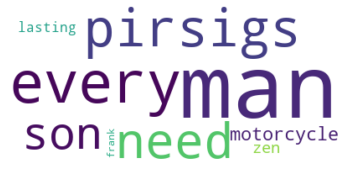

Cluster 1: doran gray picture wide oscar basil portrait henry lord young


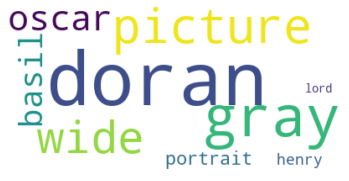

Cluster 2: date book chase boy read best mccarthy good great marion


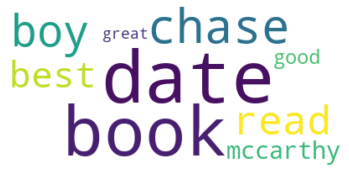

Cluster 3: book read one story great good love like quit time


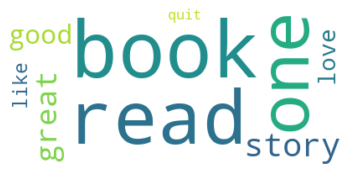

Cluster 4: doctor book read medical story carried good patient one great


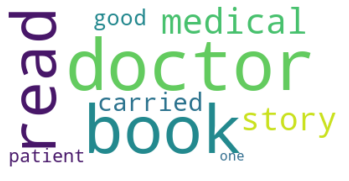

Cluster 5: movie fly book old read favorite like ready version good


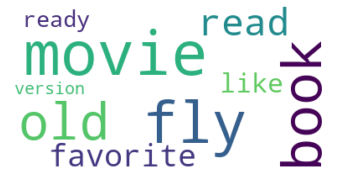

Cluster 6: program book programming amour basic learn good great use read


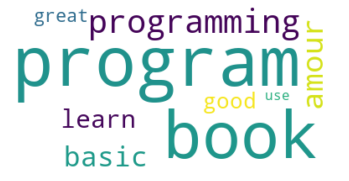

Cluster 7: up book cocci understand chesterton good read access great upon


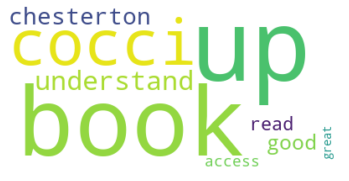

Cluster 8: decision call vocational guide temperament personal career purpose comprise live


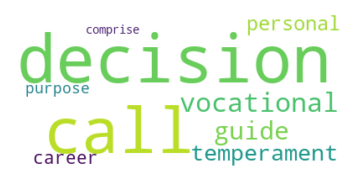

Cluster 9: history dachshund lsat incredible book fiction patagonia read bradburymartian great


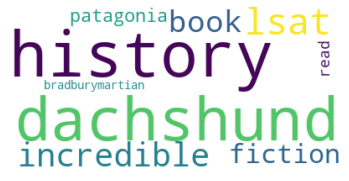

Cluster 10: marriage book dorothea casaubon woman husband help read relationship marry


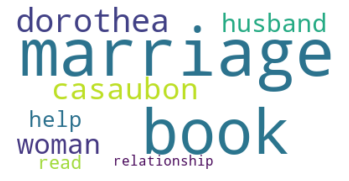

Cluster 11: recommend book would read great good anyone highly love easy


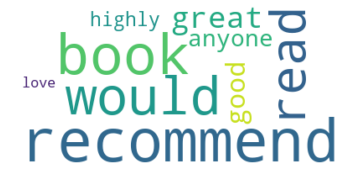

Cluster 12: thank price law book great encounter madison stitch good page


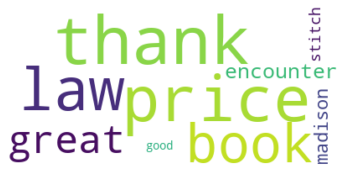

Cluster 13: welsh lapidary cover prokofy poetry comment wiring fascinating referencing plunging


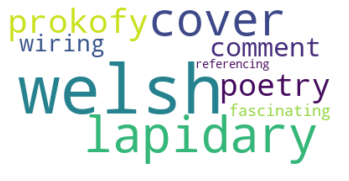

Cluster 14: femora sign line baby book hat red splendid photo love


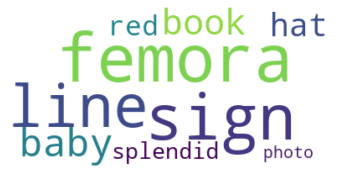

Cluster 15: philbrick whale essex pawtucket crew whaleboat pacific neville sea ship


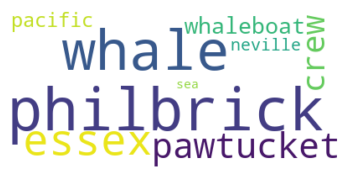

Cluster 16: advantage book read suspenseful hook take great bay one reader


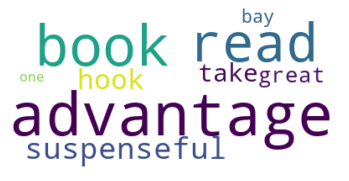

-------------------------------------------------
Enter the action: 
quit


In [ ]:
# extract keywords and guess topics for each cluster
# (use 'k', 'c', 'g' actions to get keywords, categories and genres, respectively; use 'h' for help and 'q' for quit)
# (you can select one cluster using the relative number or all clusters using 'all')
quit = False
while not quit:
  print("Enter the action ('h' for help): ")
  action = input()

  if action == 'q':
    quit = True
    continue
  
  if action == 'h':
    print("Enter 'k' for keywords, 'c' for categories and 'g' for genres")
    print("Enter 'q' for quit")
    continue

  print("Enter a number between 0 and {} to identify a cluster (or 'all'): ".format(k-1))
  n = input()

  if n == 'all':
    n = -1

  if action == 'k':
    n_keywords = 10
    wc = WordCloud(background_color="white", max_words=n_keywords)
  if action == 'c':
    n_keywords = 10
    occ = {elem: 0 for elem in categories}
  if action == 'g':
    n_keywords = 200
    occ = {elem: 0 for elem in genres}
  
  for i in range(k):
    if i == int(n) or n == -1:
      centroid_features = list(map(lambda ind: terms[ind], centroids[i, :n_keywords]))

      if action == 'k':
        print("Cluster {}: {}".format(i, ' '.join([term for term in centroid_features])))

        wc.generate_from_frequencies({term: freq for freq, term in enumerate(centroid_features[::-1])})
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

      if action == 'c':
        occ = {k: (v+1 if k in centroid_features else v) for k, v in occ.items()}
        print("Cluster {}: {}".format(i, ' '.join([term for term in centroid_features if term in categories])))

      if action == 'g':
        occ = {k: (v+1 if k in centroid_features else v) for k, v in occ.items()}
        print("Cluster {}: {}".format(i, ' '.join([term for term in centroid_features if term in genres])))
    
  if (action == 'c' or action == 'g') and n == -1:
    print("Most frequent: {}".format(', '.join([elem[0] for elem in sorted(occ.items(), key=lambda x: x[1], reverse=True)[:3]])))
    
  print("-------------------------------------------------")